In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


def extract_audio_paths(dir_path):
    audio_paths = []
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if file.endswith(".wav") and not file.startswith("._"):
                audio_path = os.path.join(root, file)
                try:
                    librosa.load(audio_path, sr=None)
                    audio_paths.append(audio_path)
                except (Exception, librosa.LibrosaError) as e:
                    print(f"Warning: Error loading file '{audio_path}': {e}")
    return audio_paths

audio_dir = Path("D:\SoundExploration")
audio_paths = extract_audio_paths(audio_dir)


C:\Users\Serj\AppData\Local\Temp\ipykernel_17752\1534069144.py:24: UserWarning: PySoundFile failed. Trying audioread instead.
  librosa.load(audio_path, sr=None)
C:\Users\Serj\anaconda3\Lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [2]:
def extract_features(audio_path):
    y, sr = librosa.load(audio_path)
    n_fft = min(2048, len(y))
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=6, n_fft=n_fft, n_mels=128)  # Utilizziamo solo i primi 6 coefficienti MFCC
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft)[0]
    zcr = librosa.feature.zero_crossing_rate(y)[0]
    return np.concatenate([mfccs.mean(axis=1), [np.mean(spectral_centroid)], [np.mean(zcr)]])

features = []
for audio_path in audio_paths:
    features.append(extract_features(audio_path))

C:\Users\Serj\anaconda3\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


In [3]:
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features_scaled)

In [4]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(reduced_features)


KMeans(n_clusters=3, n_init=10, random_state=0)

In [5]:
clusters = {}
for i, label in enumerate(kmeans.labels_):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(audio_paths[i])

In [6]:
for cluster_label, file_paths in clusters.items():
    count = 0
    for file_path in file_paths:
        count += 1
    print(f"Cluster {cluster_label}: {count} samples")


Cluster 1: 11821 samples
Cluster 0: 5902 samples
Cluster 2: 8361 samples


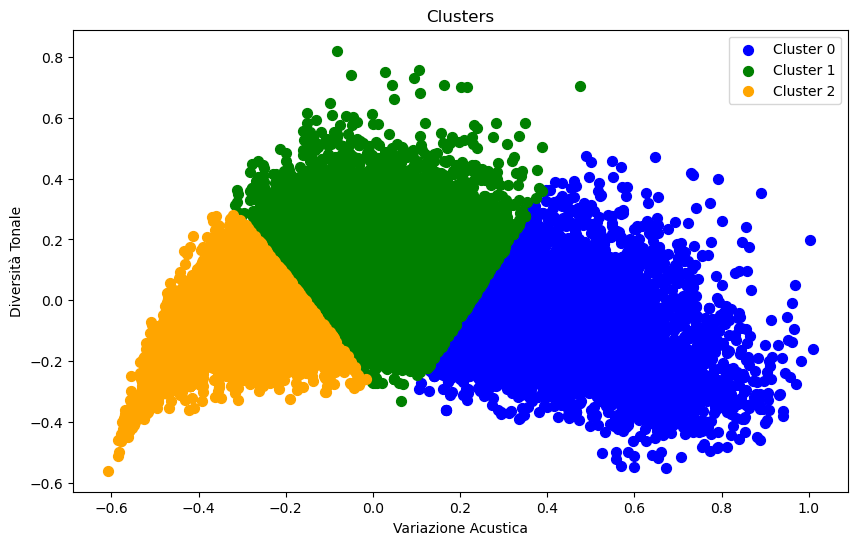

In [7]:
cluster_colors = {0: 'blue', 1: 'green', 2: 'orange'}

fig, ax = plt.subplots(figsize=(10, 6))
for label, color in cluster_colors.items():
    cluster_points = reduced_features[kmeans.labels_ == label]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], c=color, label=f'Cluster {label}', s=50)

ax.legend()

ax.set_xlabel('Variazione Acustica')
ax.set_ylabel('Diversità Tonale')
ax.set_title('Clusters')

plt.show()

clusters = {}
for i, label in enumerate(kmeans.labels_):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(audio_paths[i])

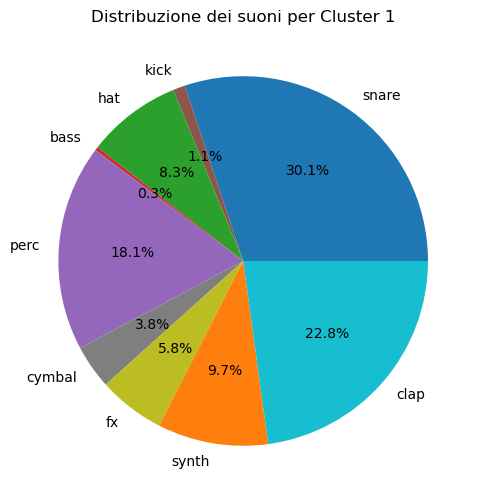

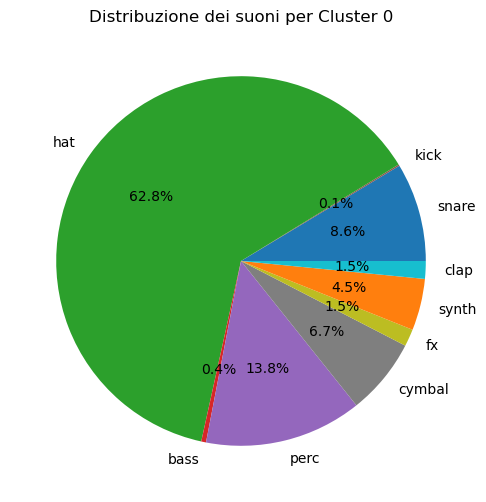

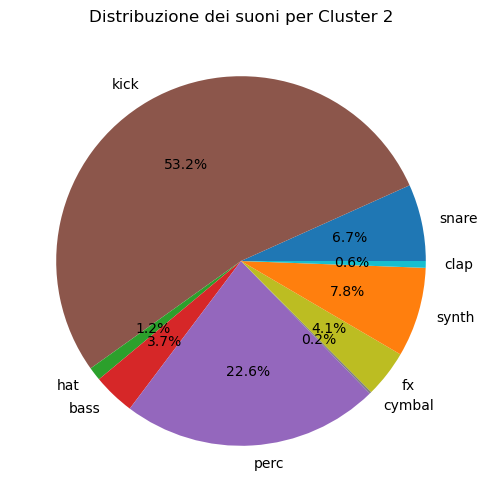

In [8]:
instruments = ["snare", "kick", "hat", "bass", "perc", 
               "cymbal", "fx", "synth", "clap"]

data = {
    'Cluster': [],
    'Instrument': [],
    'Count': []
}

for cluster_label, file_paths in clusters.items():
    for instrument in instruments:
        count = sum(instrument in file_path for file_path in file_paths)
        if count > 0:
            data['Cluster'].append(cluster_label)
            data['Instrument'].append(instrument)
            data['Count'].append(count)

df = pd.DataFrame(data)

df['Total'] = df.groupby('Cluster')['Count'].transform('sum')

df['Percentage'] = (df['Count'] / df['Total']) * 100

colors = {
    'snare': 'tab:blue',
    'kick': 'tab:brown',
    'hat': 'tab:green',
    'bass': 'tab:red',
    'perc': 'tab:purple',
    'cymbal': 'tab:gray',
    'fx': 'tab:olive',
    'synth': 'tab:orange',
    'clap': 'tab:cyan'
}

for cluster in df['Cluster'].unique():
    plt.figure(figsize=(8, 6))
    cluster_data = df[df['Cluster'] == cluster]
    plt.pie(cluster_data['Percentage'], labels=cluster_data['Instrument'], autopct='%1.1f%%', colors=[colors[instrument] for instrument in cluster_data['Instrument']])
    plt.title(f'Distribuzione dei suoni per Cluster {cluster}')
    plt.show()


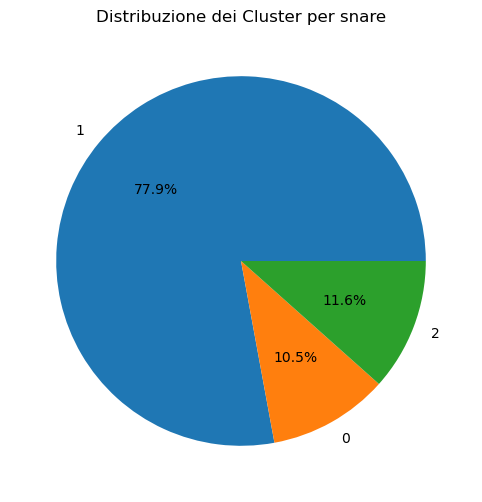

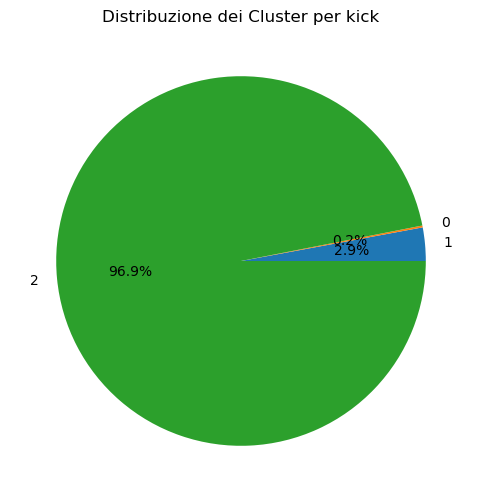

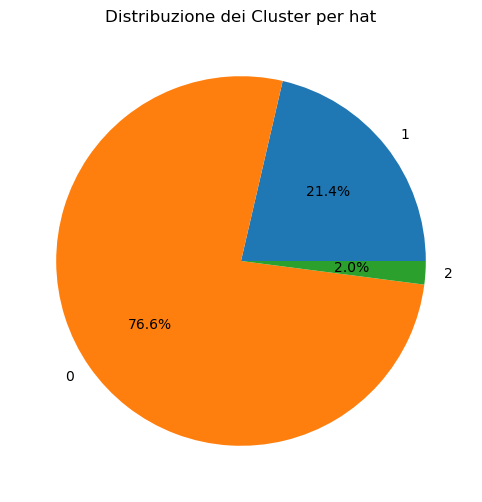

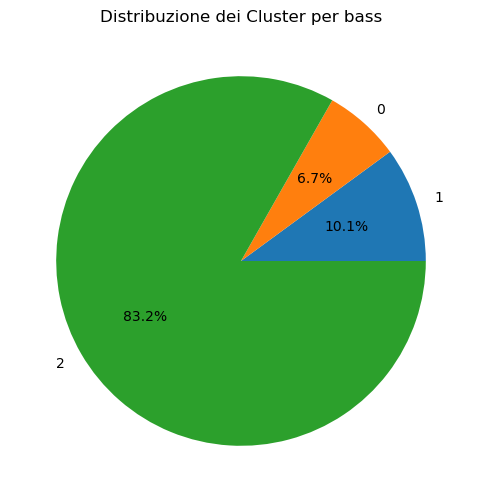

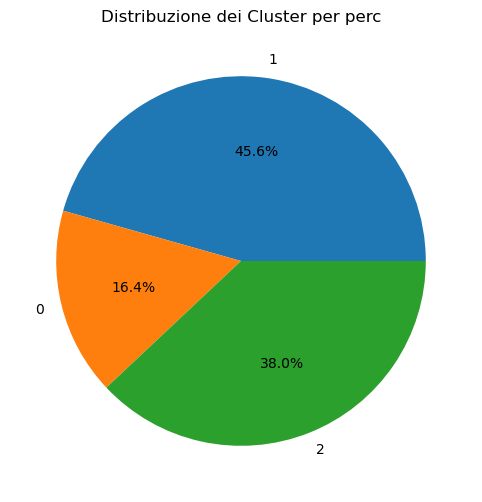

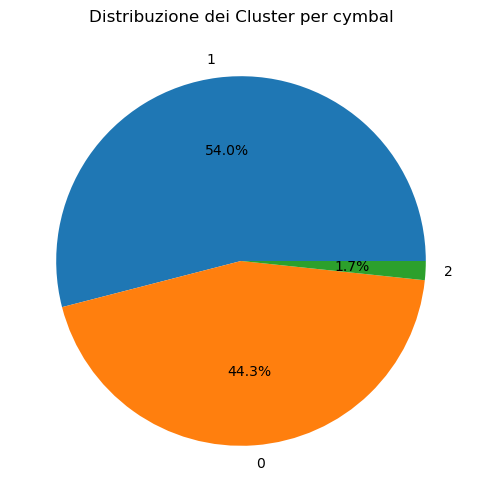

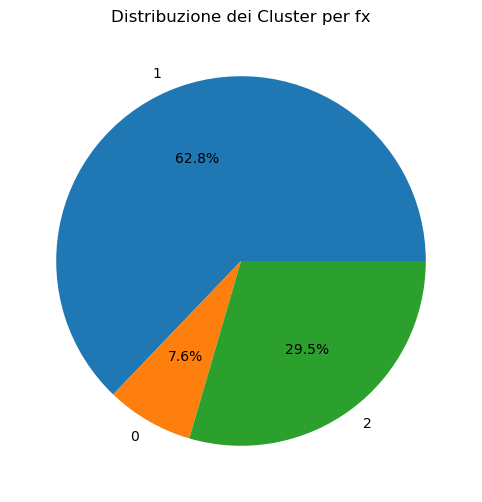

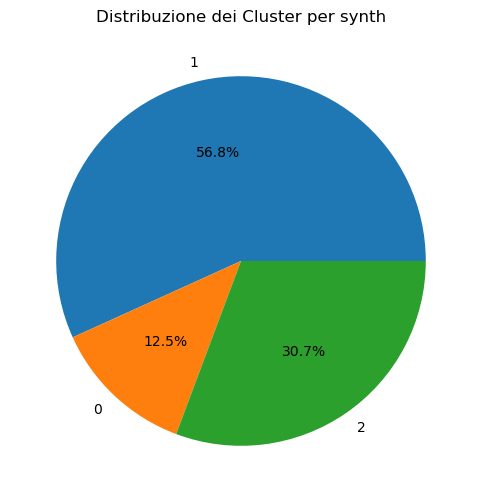

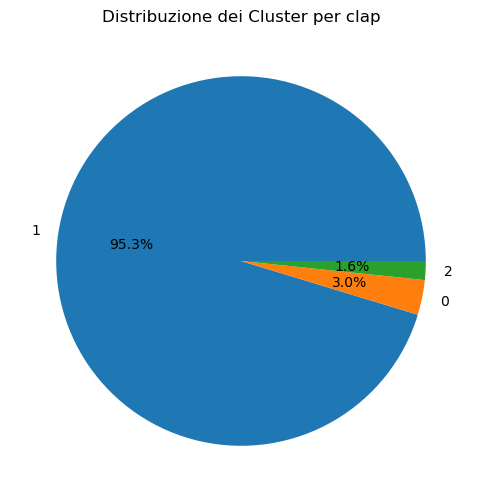

In [9]:
instruments = ["snare", "kick", "hat", "bass", "perc",
               "cymbal", "fx", "synth", "clap"]

data = {
    'Cluster': [],
    'Instrument': [],
    'Count': []
}

for cluster_label, file_paths in clusters.items():
    for instrument in instruments:
        count = sum(instrument in file_path for file_path in file_paths)
        if count > 0:
            data['Cluster'].append(cluster_label)
            data['Instrument'].append(instrument)
            data['Count'].append(count)

df = pd.DataFrame(data)

df['Total'] = df.groupby('Instrument')['Count'].transform('sum')

df['Percentage'] = (df['Count'] / df['Total']) * 100

for instrument in df['Instrument'].unique():
    plt.figure(figsize=(8, 6))
    instrument_data = df[df['Instrument'] == instrument]
    plt.pie(instrument_data['Percentage'], labels=instrument_data['Cluster'], autopct='%1.1f%%')
    plt.title(f'Distribuzione dei Cluster per {instrument}')
    plt.show()

    

In [10]:
model = SVC()

X_train, X_test, y_train, y_test = train_test_split(reduced_features, kmeans.labels_, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

cv_scores = cross_val_score(model, reduced_features, kmeans.labels_, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", np.mean(cv_scores))

Cross-Validation Scores: [0.99846655 0.99635806 0.99865823 0.9969331  0.9978911 ]
Mean Cross-Validation Score: 0.9976614104314472


In [11]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.998466551658041
Precision: 0.9984747169630555
Recall: 0.998466551658041
F1 Score: 0.9984672736893643


Confusion Matrix:
[[1159    0    0]
 [   7 2310    1]
 [   0    0 1740]]


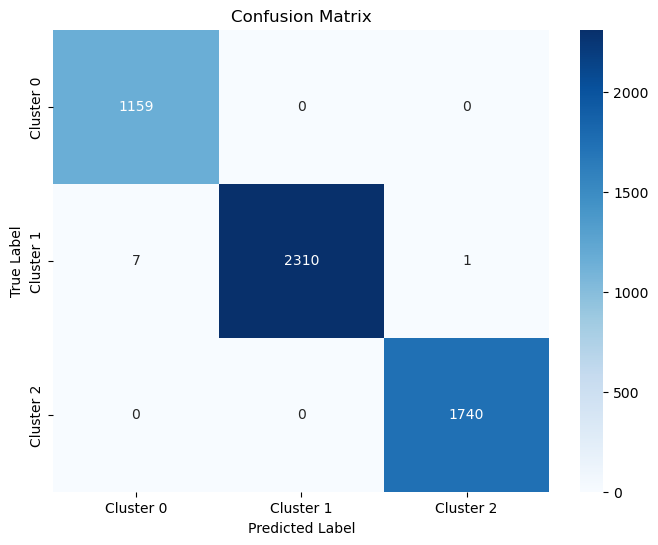

In [12]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', 
            xticklabels=['Cluster 0', 'Cluster 1', 'Cluster 2'], 
            yticklabels=['Cluster 0', 'Cluster 1', 'Cluster 2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()